Librariile necesare pentru acest model.
TensorFlow pentru ML, cu asta facem ANN
Pandas pentru prelucrarea si extragerea datelor din fisiere
numpy pentru metode numerice si prelucrearea de vectori
Matplotplib pentru grafice
Sklearn.preprocessing: pentru normalizarea si transformarea datelor de clasificare
Sklearn.Model_selection: pentru impartirea datelor in date de antrenare, date de test si date de validare
Sklearn.Compose: Pentru construirea unor atribute din Pipeline
Sklean.Pipeline: Pentru creearea unui pipeline care modeleaza datele in forme specifice
Sklearn.Ensemble: In caz in care avem de a face cu date tabulare, putem incerca RandomForest care merge mai bine
gzip si os pentru comenzi legate de OS si slavarea datelor
seaborn pentru unele prelucrari legate de interpretare
Sklearn.metrics: aici avem librarii si functii care sunt specifice interpretarii performantelor modelelor
Callback urile sunt pentru tunarea retelei, ca sa nu facem antrenare in gol, previne overfitting si optimizeaza
Functii de activare PReLU care gaseste parametrul alpha intern si LeakyRelu care e RELU doar ca avem un mic bias ca neuronii sa nu se blocheze daca au 0


In [1]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder,OneHotEncoder,LabelBinarizer,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import gzip
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import PReLU,LeakyReLU
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix


tfk = tf.keras
tfkl = tf.keras.layers

#verific ce versiune de TensorFlow rulez
print (tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
print("Număr GPU-uri disponibile:", len(gpu_devices))

if len(gpu_devices) > 0:
    print("GPU detectat cu succes!")
    print("Detalii GPU:", gpu_devices[0])
else:
    print("ATENȚIE: GPU-ul nu a fost detectat de TensorFlow.")


2025-07-17 11:43:57.452378: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 11:43:57.453049: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 11:43:57.455817: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 11:43:57.462118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752741837.471922   50904 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752741837.47

ModuleNotFoundError: No module named 'tensorflow.keras'

Citirea datelor din fisiere, am creat data set uri pentru fiecare limba

In [ ]:
def citire(folder_path,language_name): 
    file_contents = []
    file_list = os.listdir(folder_path)
    for file_name in file_list:
    # Verifică dacă este un fișier text
        if file_name.endswith(".txt"):
        # Construiește calea completă către fișier
            file_path = os.path.join(folder_path, file_name)
        # Deschide și citește conținutul fișierului
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            # Adaugă un dicționar cu numele fișierului și conținutul său în listă
                file_contents.append(content)
    data = pd.DataFrame(file_contents,columns=['text'])
    data['language'] = language_name
    return data

data_en = citire("/home/alexandru/Practica_Computing/5/Texts_three_languages/Texts_three_languages/texts_english","en")
data_fr = citire("/home/alexandru/Practica_Computing/5/Texts_three_languages/Texts_three_languages/texts_french","fr")
data_pl = citire("/home/alexandru/Practica_Computing/5/Texts_three_languages/Texts_three_languages/texts_polish","pl")

print(data_en)
#print(data_fr.head())
#print(data_pl.head())

data = pd.concat([data_en,data_fr,data_pl],ignore_index=True)


<bound method DataFrame.__len__ of                                                 text language
0  Book II identifies "nature" (physis) as "a sou...       en
1  In the sixth book, Harry Potter and the Half-B...       en
2  The rules for the scientific names of organism...       en
3  Blumenbach was appointed extraordinary profess...       en
4  Astronomy\nKepler's supernova\nTycho Brahe and...       en
5  When the first novel of the series, Harry Pott...       en
6  During a rainstorm in Derry, Maine, a six-year...       en
7  Galileo was born in Pisa (then part of the Duc...       en
8  The novel is set in rural England in the early...       en
9  Jane Eyre, aged 10, lives at Gateshead Hall wi...       en>


In [28]:
def shannon_entropy(text):
    if not text:
        return 0
    
    char_counts = Counter(text)    
    text_len = len(text)

    entropy = 0.0

    for char in char_counts:
        p = char_counts[char] / text_len
        #Formula entropieie, suma de probabilitati
        entropy -= p * np.log2(p)
    
    return entropy

lista = []

for textul in data['text']:
    rez = shannon_entropy(textul)
    lista.append(rez)

data['entropy'] = lista

print (data.head())
print("\nEntropia medie pe limbă:")
print(data.groupby('language')['entropy'].mean())


                                                text language   entropy
0  Book II identifies "nature" (physis) as "a sou...       en  4.475464
1  In the sixth book, Harry Potter and the Half-B...       en  4.456870
2  The rules for the scientific names of organism...       en  4.477701
3  Blumenbach was appointed extraordinary profess...       en  4.598050
4  Astronomy\nKepler's supernova\nTycho Brahe and...       en  4.537766

Entropia medie pe limbă:
language
en    4.485252
fr    4.466260
pl    4.747189
Name: entropy, dtype: float64


In [39]:
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,5), max_features=1000)

X_text_features = vectorizer.fit_transform(data['text'])

#print (X_text_features)

X_entropy_features = data[['entropy']].values
#print(X_entropy_features)

scaler = StandardScaler()
X_entropy_scaled = scaler.fit_transform(X_entropy_features)
#print(X_entropy_scaled)

# Combinăm caracteristicile textuale (matrice rară) cu cea de entropie
X_combined = hstack([X_text_features,csr_matrix(X_entropy_scaled)])
print (X_combined)

# Transformăm etichetele text (english, french, polish) în numere (0, 1, 2)
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(data['language'])


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 19446 stored elements and shape (30, 1001)>
  Coords	Values
  (0, 301)	0.022496236532478207
  (0, 693)	0.031861094062329766
  (0, 678)	0.01842237669112944
  (0, 561)	0.01475675744556345
  (0, 77)	0.12311569930363417
  (0, 497)	0.00951539173142611
  (0, 506)	0.00890896010500249
  (0, 342)	0.04401437582441388
  (0, 425)	0.06439898117420864
  (0, 651)	0.05303445508464241
  (0, 878)	0.09091033608795517
  (0, 514)	0.014106674723584593
  (0, 463)	0.035476841494467434
  (0, 507)	0.022729052179132462
  (0, 441)	0.07292237574138331
  (0, 788)	0.18990544564685508
  (0, 0)	0.02039852739190069
  (0, 625)	0.03314653442790151
  (0, 285)	0.08996916487573267
  (0, 894)	0.0352115006595311
  (0, 917)	0.04166992899507618
  (0, 758)	0.05966376197022272
  (0, 1)	0.0460559417278236
  (0, 721)	0.010233100508760449
  (0, 967)	0.012297297871302874
  :	:
  (29, 333)	0.018472977201143267
  (29, 784)	0.036945954402286534
  (29, 92)	0.055418931603429804

Separarea setului de date

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_data, test_size=0.2, random_state=42, stratify=y_data
)

print("Dimensiune set antrenament (X):", X_train.shape)
print("Dimensiune set testare (X):", X_test.shape)

Dimensiune set antrenament (X): (24, 1001)
Dimensiune set testare (X): (6, 1001)


In [ ]:
input_dim = X_train.shape[0]
print(input_dim)
epochs = 200
batch_size = 32

output_dim = len(label_encoder.classes_)
print(output_dim)

model_language = tfk.Sequential ([
    tfkl.Dense(128, activation = PReLU(), name = "Hidden_Layer_1", kernel_initializer = "random_uniform", bias_initializer = "random_uniform"),
    tfkl.Dropout(0.4),
    tfkl.BatchNormalization(),
    tfkl.Dense(64, activation = PReLU(), name = "Hidden_Layer_2", kernel_initializer = "random_uniform", bias_initializer = "random_uniform"),
    tfkl.Dropout(0.3),
    tfkl.BatchNormalization(),
    tfkl.Dense(64, activation = PReLU(), name = "Hidden_Layer_3", kernel_initializer = "random_uniform", bias_initializer = "random_uniform"),
    tfkl.Dropout(0.3),
    tfkl.BatchNormalization(),
    tfkl.Dense(output_dim,activation="softmax")
])


opt = tfk.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)


model_language.compile(
    optimizer = opt,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model_language.summary()

history = model_language.fit(
     X_train.toarray(), y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    validation_data=(X_test, y_test)
)

loss, accuracy = model_language.evaluate(X_test, y_test)
print(f"\nAcuratețe pe setul de testare: {accuracy * 100:.2f}%")


1001
3


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3333 - loss: 1.3281 - val_accuracy: 0.3333 - val_loss: 1.0981 - learning_rate: 1.0000e-04
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3333 - loss: 1.6287 - val_accuracy: 0.3333 - val_loss: 1.0981 - learning_rate: 1.0000e-04
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5000 - loss: 1.2224 - val_accuracy: 0.3333 - val_loss: 1.0981 - learning_rate: 1.0000e-04
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5417 - loss: 1.2791 - val_accuracy: 0.3333 - val_loss: 1.0980 - learning_rate: 1.0000e-04
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.4167 - loss: 1.1984 - val_accuracy: 0.3333 - val_loss: 1.0979 - learning_rate: 1.0000e-04
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3333 - loss: 1.2513 - val_accuracy: 0.3333 - val_loss: 1.0978 - learning_rate: 1.0000e-04
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4583 - l

KeyboardInterrupt: 

In [55]:
def predict_language(text_sample):
    # 1. Calculează entropia pentru textul nou
    entropy = shannon_entropy(text_sample)
    entropy_scaled = scaler.transform([[entropy]]) # Aplicăm același scaler
    
    # 2. Vectorizează textul nou
    text_vectorized = vectorizer.transform([text_sample])
    
    # 3. Combină caracteristicile
    combined_features = hstack([text_vectorized, csr_matrix(entropy_scaled)])
    
    # 4. Fă predicția
    prediction_probabilities = model_language.predict(combined_features.toarray())[0]
    
    # 5. Găsește clasa cu cea mai mare probabilitate
    predicted_class_index = np.argmax(prediction_probabilities)
    predicted_language = label_encoder.inverse_transform([predicted_class_index])[0]
    confidence = prediction_probabilities[predicted_class_index]
    
    print(f"Text: '{text_sample}'")
    print(f"Limbă Prezisa: {predicted_language} (Încredere: {confidence*100:.2f}%)")

# Testăm
predict_language("This is a test sentence in English.")
predict_language("Ceci est une phrase de test en français.")
predict_language("To jest zdanie testowe w języku polskim.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Text: 'This is a test sentence in English.'
Limbă Prezisa: en (Încredere: 90.23%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Text: 'Ceci est une phrase de test en français.'
Limbă Prezisa: en (Încredere: 81.15%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Text: 'To jest zdanie testowe w języku polskim.'
Limbă Prezisa: en (Încredere: 57.83%)


In [48]:

def evalueaza_model_multiclasa(y_test, y_pred_proba, label_encoder):
    """
    Evaluează și vizualizează performanța unui model de clasificare multi-clasă.
    """
    # --- Conversia probabilităților în clasa cu cea mai mare probabilitate ---
    y_pred_clasa = np.argmax(y_pred_proba, axis=1)
    
    # --- Raport de Performanță ---
    print("--- RAPORT DE PERFORMANȚĂ (CLASIFICARE MULTI-CLASĂ) ---\n")
    print("Raport de Clasificare Detaliat:")
    print(classification_report(y_test, y_pred_clasa, target_names=label_encoder.classes_))
    
    # --- Vizualizări ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Matricea de Confuzie
    cm = confusion_matrix(y_test, y_pred_clasa)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax1,
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    ax1.set_title('Matricea de Confuzie', fontsize=16)
    ax1.set_ylabel('Valoare Reală', fontsize=12)
    ax1.set_xlabel('Valoare Prezisă', fontsize=12)

    
    # 1. Inițializăm binarizatorul
    lb = LabelBinarizer()

    # 2. Îl "învățăm" pe toate clasele posibile și transformăm y_test
    #    Folosim y_train pentru a fi siguri că binarizatorul cunoaște toate clasele
    lb.fit(y_train) 
    y_test_binarized = lb.transform(y_test)
    
    # Plotează curba ROC pentru fiecare clasă
    for i, class_name in enumerate(label_encoder.classes_):
        # Asigură-te că există predicții pentru clasa curentă
        if i < y_pred_proba.shape[1]:
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
            auc = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
            ax2.plot(fpr, tpr, lw=2, label=f'ROC pt. clasa {class_name} (AUC = {auc:.2f})')
        
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_xlabel('Rata Fals Pozitivelor (FPR)', fontsize=12)
    ax2.set_ylabel('Rata Adevărat Pozitivelor (TPR)', fontsize=12)
    ax2.set_title('Curbe ROC Multi-clasă (One-vs-Rest)', fontsize=16)
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

In [51]:
def ploteaza_curbe_invatare(history, model_name):
    """
    Plotează curbele de loss și acuratețe pentru antrenare și validare.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Curbe de Învățare pentru Modelul: {model_name}', fontsize=16)

    # Graficul pentru Loss
    ax1.plot(history.history['loss'], label='Loss Antrenare')
    ax1.plot(history.history['val_loss'], label='Loss Validare')
    ax1.set_title('Evoluția Funcției de Pierdere')
    ax1.set_xlabel('Epocă')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Graficul pentru Acuratețe
    ax2.plot(history.history['accuracy'], label='Acuratețe Antrenare')
    ax2.plot(history.history['val_accuracy'], label='Acuratețe Validare')
    ax2.set_title('Evoluția Acurateței')
    ax2.set_xlabel('Epocă')
    ax2.set_ylabel('Acuratețe')
    ax2.legend()
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
--- RAPORT DE PERFORMANȚĂ (CLASIFICARE MULTI-CLASĂ) ---

Raport de Clasificare Detaliat:
              precision    recall  f1-score   support

          en       1.00      1.00      1.00         2
          fr       1.00      1.00      1.00         2
          pl       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



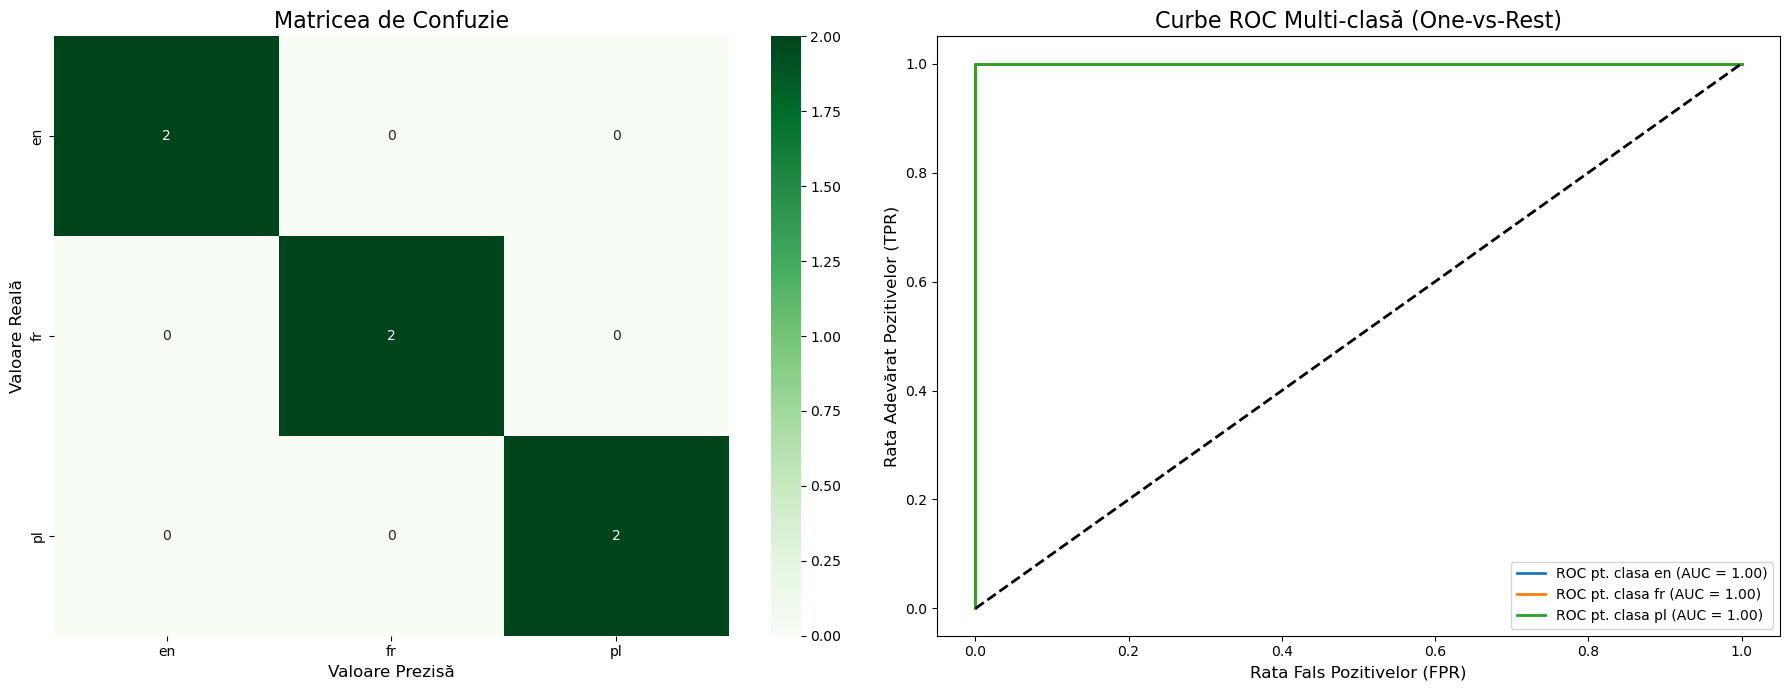

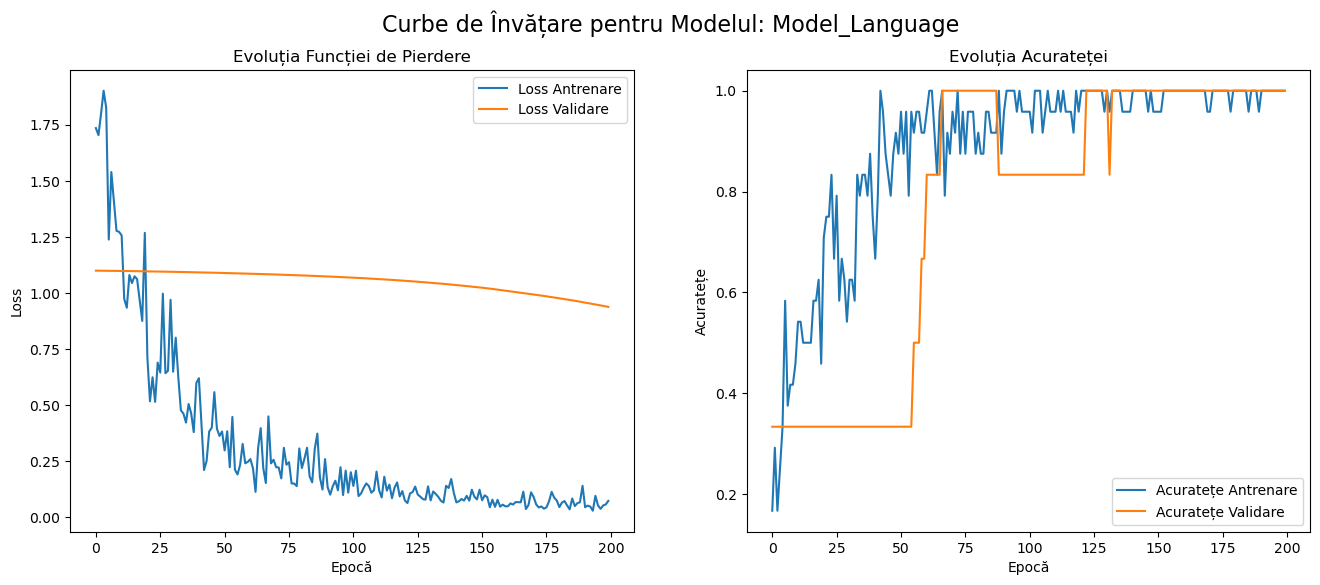

In [57]:
y_pred_risk = model_language.predict(X_test)
evalueaza_model_multiclasa(y_test,y_pred_risk,label_encoder)
ploteaza_curbe_invatare(history, "Model_Language")
